# Image_ML

## 공통 코드

In [47]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
#assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import pandas as pd

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Image_ML"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action='ignore')

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Open CV를 이용한 MNIST 데이터 가져오기

In [ ]:
''' ref1: http://yann.lecun.com/exdb/mnist/
    ref2: https://gist.github.com/ischlag/41d15424e7989b936c1609b53edd1390
'''
import gzip
import cv2

IMAGE_SIZE = 28
PIXEL_DEPTH = 255
NUM_LABELS = 10

#1
def extract_data(filename, num_images):
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE)
    return data

def extract_labels(filename, num_images):
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
  return labels

def ont_hot_encoding(y):
    t = np.zeros((y.size, 10), dtype=np.float32)
    for i, row in enumerate(t):
        row[y[i]] = 1
    return t

def load_MNIST(flatten=True, one_hot=True):
  x_train=extract_data('./data/MNIST/train-images-idx3-ubyte.gz',  60000)
  y_train=extract_labels('./data/MNIST/train-labels-idx1-ubyte.gz',60000)
  x_test =extract_data('./data/MNIST/t10k-images-idx3-ubyte.gz',   10000)
  y_test =extract_labels('./data/MNIST/t10k-labels-idx1-ubyte.gz', 10000)

  if flatten:
    x_train= x_train.reshape(-1, IMAGE_SIZE*IMAGE_SIZE) # (60000, 784)
    x_test = x_test.reshape(-1, IMAGE_SIZE*IMAGE_SIZE)  # (10000, 784)
  if one_hot:
    y_train = ont_hot_encoding(y_train)
    y_test = ont_hot_encoding(y_test)
  return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_MNIST()
print('x_train.shape=', x_train.shape) # (60000, 784)
print('y_train.shape=', y_train.shape) # (60000, 10)
print('x_test.shape=',  x_test.shape)  # (10000, 784)
print('y_test.shape=',  y_test.shape)  # (10000, 10)

x_train.shape= (60000, 784)
y_train.shape= (60000, 10)
x_test.shape= (10000, 784)
y_test.shape= (10000, 10)


In [ ]:
dst = np.zeros((20*IMAGE_SIZE, 20*IMAGE_SIZE), dtype=np.uint8)
for i in range(400):
  x = i%20
  y = i//20
  x1 = x*IMAGE_SIZE
  y1 = y*IMAGE_SIZE
  x2 = x1+IMAGE_SIZE
  y2 = y1+IMAGE_SIZE

  img = x_train[i].astype(np.uint8)
  img = img.reshape(IMAGE_SIZE, IMAGE_SIZE)
  dst[y1:y2, x1:x2] = img

cv2.imshow('MINIST 400', dst)
cv2.waitKey()
cv2.destroyAllWindows()

## OpenCV 의 인공 신경망 분류 모델

### 2층 신경망 랜덤 샘플링 미니배치

train_accuracy[0]=0.86325, train_loss=2.1295654947916667
train_accuracy[60]=0.8848166666666667, train_loss=2.053199609375
train_accuracy[120]=0.89245, train_loss=2.0264313802083334
train_accuracy[180]=0.8985333333333333, train_loss=1.9975872395833334
train_accuracy[240]=0.8971166666666667, train_loss=2.014638671875
train_accuracy[300]=0.9014833333333333, train_loss=1.978968359375
train_accuracy[360]=0.9114833333333333, train_loss=1.9372390625
train_accuracy[420]=0.9099666666666667, train_loss=1.9460244791666668
train_accuracy[480]=0.9135833333333333, train_loss=1.943309765625
train_accuracy[540]=0.9178666666666667, train_loss=1.9165924479166667
train_accuracy[600]=0.9166833333333333, train_loss=1.924881640625
train_accuracy[660]=0.9213166666666667, train_loss=1.90515546875
train_accuracy[720]=0.9172, train_loss=1.9210135416666667
train_accuracy[780]=0.91715, train_loss=1.9098817708333333
train_accuracy[840]=0.9173333333333333, train_loss=1.9090712239583334
train_accuracy[900]=0.9225666

train_accuracy[7680]=0.9462833333333334, train_loss=nan
train_accuracy[7740]=0.9458166666666666, train_loss=1.8072479166666666
train_accuracy[7800]=0.9464333333333333, train_loss=1.8068201822916667
train_accuracy[7860]=0.9474166666666667, train_loss=1.8054549479166666
train_accuracy[7920]=0.94645, train_loss=1.807644921875
train_accuracy[7980]=0.9478666666666666, train_loss=1.8100541666666667
train_accuracy[8040]=0.9486, train_loss=1.80171328125
train_accuracy[8100]=0.9468333333333333, train_loss=nan
train_accuracy[8160]=0.94665, train_loss=1.8055936197916667
train_accuracy[8220]=0.9481166666666667, train_loss=1.8032479166666666
train_accuracy[8280]=0.9468666666666666, train_loss=1.8065334635416668
train_accuracy[8340]=0.9452, train_loss=1.812134375
train_accuracy[8400]=0.94725, train_loss=1.80900078125
train_accuracy[8460]=0.9468333333333333, train_loss=1.8126975260416667
train_accuracy[8520]=0.9469333333333333, train_loss=1.81347890625
train_accuracy[8580]=0.94775, train_loss=1.80445

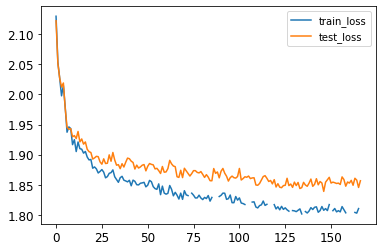

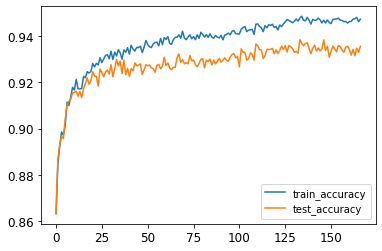

In [ ]:
#1
ann = cv2.ml.ANN_MLP_create()
ann.setLayerSizes(np.array([784, 100, 10]))
ann.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)
ann.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM)
ann.setTermCriteria((cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT,1,1e-5))

trainData = cv2.ml.TrainData_create(samples=x_train,
                                    layout=cv2.ml.ROW_SAMPLE,
                                    responses=y_train)
ret = ann.train(trainData)

#2
train_loss_list     = []
train_accuracy_list = []
test_loss_list      = []
test_accuracy_list  = []

batch_size = 1000
train_size = 60000

iters_num  = 10000
iter_per_epoch = train_size//batch_size

for i in range(iters_num):
#2-1
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  y_batch = y_train[batch_mask]

  trainData = cv2.ml.TrainData_create(samples=x_batch,
                                      layout=cv2.ml.ROW_SAMPLE,
                                      responses=y_batch)
  ret = ann.train(trainData, flags=cv2.ml.ANN_MLP_UPDATE_WEIGHTS)

#2-2
  if i % iter_per_epoch == 0:
    y_target = np.argmax(y_train, axis=1)
    ret, res_train = ann.predict(x_train)
    y_predict = np.argmax(res_train, axis = 1)
    train_accuracy = np.sum(y_target==y_predict)/len(y_target)
    train_loss = np.sum((y_train-res_train)**2)
    train_loss /= x_train.shape[0] # 60000
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    y_target = np.argmax(y_test, axis=1)
    ret, res_test = ann.predict(x_test)
    y_predict = np.argmax(res_test, axis = 1)
    test_accuracy = np.sum(y_target==y_predict)/len(y_target)
    test_loss = np.sum((y_test-res_test)**2)
    test_loss /= x_test.shape[0] # 10000
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    print('train_accuracy[{}]={}, '.format(i, train_accuracy), end='')
    print('train_loss={}'.format(train_loss))

#3
ann.save('./data/ann-minist_2layer_BP.train')

x = list(range(len(train_loss_list)))
plt.plot(x, train_loss_list, label='train_loss')
plt.plot(x, test_loss_list, label='test_loss')

plt.legend(loc='best')
plt.show()

plt.plot(x, train_accuracy_list, label='train_accuracy')
plt.plot(x, test_accuracy_list, label='test_accuracy')
plt.legend(loc='best')
plt.show()


### 미니배치를 이용하지 않고 학습

train_accuracy[0]=0.9280333333333334, test_accuracy=0.903
train_accuracy[1]=0.9226833333333333, test_accuracy=0.8878
train_accuracy[2]=0.9163333333333333, test_accuracy=0.8807
train_accuracy[3]=0.9225166666666667, test_accuracy=0.8912
train_accuracy[4]=0.9298166666666666, test_accuracy=0.9021
train_accuracy[5]=0.9316333333333333, test_accuracy=0.9094
train_accuracy[6]=0.9420833333333334, test_accuracy=0.9193
train_accuracy[7]=0.94235, test_accuracy=0.9271
train_accuracy[8]=0.9459166666666666, test_accuracy=0.9287
train_accuracy[9]=0.9449, test_accuracy=0.9266
train_accuracy[10]=0.94635, test_accuracy=0.9257
train_accuracy[11]=0.94815, test_accuracy=0.9283
train_accuracy[12]=0.94775, test_accuracy=0.9266
train_accuracy[13]=0.9511833333333334, test_accuracy=0.9292
train_accuracy[14]=0.9528, test_accuracy=0.9309
train_accuracy[15]=0.95245, test_accuracy=0.9318
train_accuracy[16]=0.9544833333333334, test_accuracy=0.9326
train_accuracy[17]=0.9533166666666667, test_accuracy=0.9306
train_accu

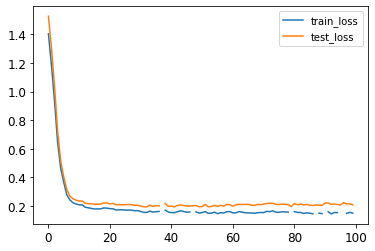

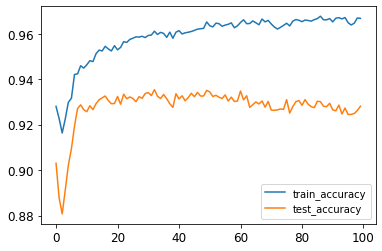

In [ ]:
#1
ann = cv2.ml.ANN_MLP_create()
ann.setLayerSizes(np.array([784, 100, 10]))
##ann.setLayerSizes(np.array([784, 50, 50, 10]))

##ann.setTrainMethod(cv2.ml.ANN_MLP_RPROP)
ann.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM)
ann.setTermCriteria((cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT,20,1e-5))

trainData = cv2.ml.TrainData_create(samples=x_train,
                                    layout=cv2.ml.ROW_SAMPLE,
                                    responses=y_train)
ret = ann.train(trainData)

#2
train_loss_list     = []
train_accuracy_list = []
test_loss_list      = []
test_accuracy_list  = []

train_size = 60000
iters_num  = 100

for i in range(iters_num):
  ret = ann.train(trainData, flags=cv2.ml.ANN_MLP_UPDATE_WEIGHTS)

  y_target = np.argmax(y_train, axis=1)
  ret, res_train = ann.predict(x_train)
  y_predict = np.argmax(res_train, axis = 1)
  train_accuracy = np.sum(y_target==y_predict)/len(y_target)
  train_loss = np.sum((y_train-res_train)**2)
  train_loss /= x_train.shape[0] # 60000
  train_accuracy_list.append(train_accuracy)
  train_loss_list.append(train_loss)

  y_target = np.argmax(y_test, axis=1)
  ret, res_test = ann.predict(x_test)
  y_predict = np.argmax(res_test, axis = 1)
  test_accuracy = np.sum(y_target==y_predict)/len(y_target)
  test_loss = np.sum((y_test-res_test)**2)
  test_loss /= x_test.shape[0] # 10000
  test_accuracy_list.append(test_accuracy)
  test_loss_list.append(test_loss)

  print('train_accuracy[{}]={}, '.format(i, train_accuracy), end='')
  print('test_accuracy={}'.format(test_accuracy))

print('train_loss={}, '.format(train_loss), end='')
print('test_loss={}'.format(test_loss))

#3
ann.save('./data/ann-minist_2layer_100RPROP.train')
##ann.save('./data/ann-minist_3layer_50RPROP.train')

x = list(range(len(train_loss_list)))
plt.plot(x, train_loss_list, label='train_loss')
plt.plot(x, test_loss_list, label='test_loss')

plt.legend(loc='best')
plt.show()

plt.plot(x, train_accuracy_list, label='train_accuracy')
plt.plot(x, test_accuracy_list, label='test_accuracy')
plt.legend(loc='best')
plt.show()

### 이전 모델을 이용한 학습

In [ ]:
#1
ann = cv2.ml_ANN_MLP.load('./data/ann-minist_2layer_BP.train')

#2
def onMouse(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.circle(dst, (x, y), 10, (255, 255, 255), -1)
    cv2.imshow('dst', dst)

dst  = np.zeros(shape=(512, 512, 3), dtype=np.uint8)
cv2.imshow('dst',dst)
cv2.setMouseCallback('dst', onMouse)

mode   = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
font = cv2.FONT_HERSHEY_SIMPLEX
x_img = np.zeros(shape=(28, 28), dtype=np.uint8)
#3
while True:
    key = cv2.waitKey(25)
    if key == 27:
        break;
    elif key == ord('r'):
        dst[:,:] = 0
        cv2.imshow('dst',dst)
    elif key == ord(' '):
        gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(gray, mode, method)

        for i, cnt in enumerate(contours):
#3-1
            x, y, width, height = cv2.boundingRect(cnt)
            cv2.rectangle(dst, (x, y), (x+width, y+height), (0,0,255), 2)
            cx, cy = x + width/2, y + height/2
            if width > height:
                r = width/2
            else:
                r = height/2
##            (cx,cy),r = cv2.minEnclosingCircle(cnt)
            cx, cy, r= int(cx), int(cy), int(r)
            img = gray[cy-r:cy+r, cx-r:cx+r]
            img = cv2.resize(img, dsize=(20, 20),interpolation=cv2.INTER_AREA)
            x_img[:,:] = 0
            x_img[4:24, 4:24] = img
            x_img = cv2.dilate(x_img, None, 2)
            x_img = cv2.erode(x_img, None, 4)
            cv2.imshow('x_img', x_img)
#3-2
            x_test = np.float32(x_img.flatten())
            _, res = ann.predict(x_test.reshape(-1, 784))
##            print('res=', res)
            y_predict = np.argmax(res, axis = 1)
            print('y_predict=', y_predict)
            digit = int(y_predict[0])
            cv2.putText(dst, str(digit), (x, y), font, 3, (255,0,0), 5)

        cv2.imshow('dst',dst)
cv2.destroyAllWindows()

y_predict= [1]
y_predict= [6]
y_predict= [0]
y_predict= [2]
y_predict= [0]
y_predict= [4]
y_predict= [2]
y_predict= [3]


## 유사 이미지 검출

### Average Hash

In [4]:
from PIL import Image

# 이미지 데이터를 Average Hash로 변환하기 --- (※1)
# 이미지에서 평균보다 크면 1, 작으면 0으로 나타내는 hash
def average_hash(fname, size = 16):
    img = Image.open(fname) # 이미지 데이터 열기---(※2)
    img = img.convert('L') # 그레이스케일로 변환하기 --- (※3)
    img = img.resize((size, size), Image.ANTIALIAS) # 리사이즈하기 --- (※4)
    pixel_data = img.getdata() # 픽셀 데이터 가져오기 --- (※5)
    pixels = np.array(pixel_data) # Numpy 배열로 변환하기 --- (※6)
    pixels = pixels.reshape((size, size)) # 2차원 배열로 변환하기 --- (※7)
    avg = pixels.mean() # 평균 구하기 --- (※8)
    diff = 1 * (pixels > avg) # 평균보다 크면 1, 작으면 0으로 변환하기 --- (※9)
    return diff

# 이진 해시로 변환하기 --- (※10)
# 실제 해시 값(이진수)으로 변환
def np2hash(ahash):
    bhash = []
    for nl in ahash.tolist():
        sl = [str(i) for i in nl]
        s2 = "".join(sl)
        i = int(s2, 2) # 이진수를 정수로 변환하기
        # 이진수를 4개씩 묶어서 16진수로 표현
        bhash.append("%04x" % i)
    return "".join(bhash)

# Average Hash 출력하기
ahash = average_hash('./images/Image_ML/lena.jpg')
print(ahash) # average hash 출력
print(np2hash(ahash)) # average hash 를 이진수로 변환해서 출력

[[1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0]
 [1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0]
 [0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0]
 [0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1]
 [0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1]
 [0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1]
 [0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1]
 [0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1]
 [0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1]
 [0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1]
 [0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1]
 [0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1]
 [0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0]
 [0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
 [0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0]
 [1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0]]
cfbccfbc43d843e943f95e7348e341e7414741ef41cf48cf40ce40fe41f4c1f0


### 많은 이미지에서 유사한 이미지 검색

In [5]:
# github 에서 이미지 데이터 가져오기
!git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (9149/9149), done.


In [7]:
from PIL import Image # Pillow 패키지가 설치되어 있어야 함
import numpy as np
import os, re

# 파일 경로 지정하기
# 유사한 이미지를 찾기 위한 이미지 파일의 경로
search_dir = "/content/Homework2-Caltech101/101_ObjectCategories"
# 캐시 디렉토리 경로 - 디렉토리가 없으면 새로 생성
cache_dir = "/content/cache_avhash"
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir) # 디렉토리를 생성하는 명령어
#%%bash
#mkdir('디렉토리 이름')
# colab 은 우분투 리눅스이기 때문에 위의 명령어도 수행 가능


# 유사한 이미지를 찾을 때마다 비교 데이터들을 전부 다시 해시로 변환할 수 없으므로
# 해시로 변환한 값을 csv 파일에 저장하고 필요한 경우에 문자열만 가지고 비교

# 이미지 데이터를 Average Hash로 변환하기 --- (※1)
def average_hash(fname, size = 16):
    fname2 = fname[len(search_dir):]

    # 이미지 캐시하기
    # 이미지가 각 디렉토리에 나눠져있기 때문에
    # 각 디렉토리의 이미지를 csv 에 넣는 작업
    cache_file = cache_dir + "/" + fname2.replace(os.sep, '_') + ".csv"

    # 캐시 디렉토리에 없으면 해시를 생성해서 저장하고(if)
    # 캐시가 있다면 읽지 않기(else)
    if not os.path.exists(cache_file): # 해시 생성하기
        img = Image.open(fname)
        # 이미지를 흑백으로 변환하고 크기 조절
        img = img.convert('L').resize((size, size), Image.ANTIALIAS)
        pixels = np.array(img.getdata()).reshape((size, size))
        avg = pixels.mean()
        px = 1 * (pixels > avg)
        # 이미지의 이진 해시를 문자열로 저장
        np.savetxt(cache_file, px, fmt="%.0f", delimiter=",")

    else:
        px = np.loadtxt(cache_file, delimiter=",")

    return px

# 해밍 거리 - 서로 다른 데이터의 갯수의 합
# 해밍 거리 구하기 --- (※2)
def hamming_dist(a, b):
    aa = a.reshape(1, -1) # 1차원 배열로 변환하기
    ab = b.reshape(1, -1)
    dist = (aa != ab).sum()
    return dist

# 모든 폴더에 처리 적용하기 --- (※3)
def enum_all_files(path):
    for root, dirs, files in os.walk(path):
        for f in files:
            fname = os.path.join(root, f)
            if re.search(r'\.(jpg|jpeg|png)$', fname):
                yield fname

# 이미지를 받아서 자신과 가장 유사한 이미지 찾기
# 이미지 찾기 --- (※4)
def find_image(fname, rate):
    # 자신의 해시를 계산
    src = average_hash(fname)
    # 이미지 디렉토리의 모든 파일과 해밍 거리를 구하기
    for fname in enum_all_files(search_dir):
        dst = average_hash(fname)
        diff_r = hamming_dist(src, dst) / 256
        # print("[check] ",fname)
        # 해밍 거리가 rate 보다 작으면 리턴
        if diff_r < rate:
            yield (diff_r, fname)

# 찾기 --- (※5)
# 의자 이미지 데이터를 가지고 확인
srcfile = search_dir + "/chair/image_0016.jpg"
html = ""
# 의자 이미지와 25 퍼센트 이내로 틀린 이미지 찾기
sim = list(find_image(srcfile, 0.25))
# 찾은 이미지를 정렬
sim = sorted(sim, key=lambda x:x[0])


for r, f in sim:
    print(r, ">", f)
    s = '<div style="float:left;"><h3>[ 차이 :' + str(r) + '-' + \
        os.path.basename(f) + ']</h3>'+ \
        '<p><a href="' + f + '"><img src="' + f + '" width=400>'+ \
        '</a></p></div>'
    html += s

# HTML로 출력하기
html = """<html><head><meta charset="utf8"></head>
<body><h3>원래 이미지</h3><p>
<img src='{0}' width=400></p>{1}
</body></html>""".format(srcfile, html)
with open("./avhash-search-output.html", "w", encoding="utf-8") as f:
    f.write(html)
print("ok")

0.0 > /content/Homework2-Caltech101/101_ObjectCategories/chair/image_0016.jpg
0.22265625 > /content/Homework2-Caltech101/101_ObjectCategories/airplanes/image_0129.jpg
0.2265625 > /content/Homework2-Caltech101/101_ObjectCategories/chair/image_0031.jpg
0.2265625 > /content/Homework2-Caltech101/101_ObjectCategories/stop_sign/image_0019.jpg
0.234375 > /content/Homework2-Caltech101/101_ObjectCategories/umbrella/image_0009.jpg
0.23828125 > /content/Homework2-Caltech101/101_ObjectCategories/airplanes/image_0124.jpg
0.24609375 > /content/Homework2-Caltech101/101_ObjectCategories/chair/image_0001.jpg
0.24609375 > /content/Homework2-Caltech101/101_ObjectCategories/dragonfly/image_0001.jpg
ok


## Object Detection

### Open CV를 활용한 이미지에서 얼굴 검출

#### 이미지 검출을 위한 라이브러리 다운로드 - Open CV

In [41]:
!git clone https://github.com/opencv/opencv.git

Cloning into 'opencv'...
remote: Enumerating objects: 320875, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 320875 (delta 3), reused 7 (delta 3), pack-reused 320853
Receiving objects: 100% (320875/320875), 508.52 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (223540/223540), done.
Updating files: 100% (7211/7211), done.


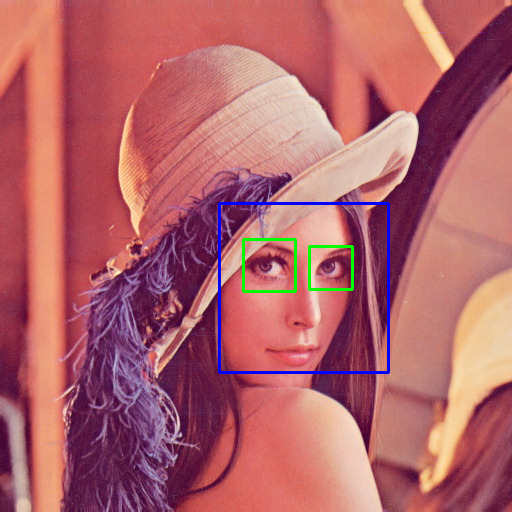

In [44]:
# Open CV 를 이용해서 이미지에서 얼굴과 눈을 검출

# ref: https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html
import numpy as np
import cv2

# 얼굴을 검출하기 위한 정보를 로드
faceCascade= cv2.CascadeClassifier(
      'opencv/data/haarcascades/haarcascade_frontalface_default.xml')
# 눈을 검출하기 위한 정보를 로드
eyeCascade = cv2.CascadeClassifier(
    'opencv/data/haarcascades/haarcascade_eye.xml')

# 검출에 사용할 이미지 파일
src = cv2.imread('/content/images/Image_ML/lena.jpg')
# 사용할 이미지를 흑백(gray)으로 변환
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
# 얼굴 검출
faces = faceCascade.detectMultiScale(gray, 1.1, 3) #(gray, 1.1, 0)

# 얼굴을 순회
for (x, y, w, h) in faces:
    # 얼굴에 사각형 그리기
    cv2.rectangle(src, (x,y),(x+w, y+h),(255,0,0), 2)
    # 얼굴 영역에서 눈을 검출
    roi_gray  = gray[y:y+h, x:x+w]
    roi_color = src[y:y+h, x:x+w]

    eyes = eyeCascade.detectMultiScale(roi_gray)
    # 눈 영역에 녹색 사각형 그리기
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

'''
cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()
'''

# opencv 는 RGB 가 아니고 BGR
from google.colab.patches import cv2_imshow
cv2_imshow(src)

### 유투브 동영상에서 검출

In [ ]:
'''
 pip install youtube_dl
 pip install pafy
'''

import pafy

faceCascade= cv2.CascadeClassifier(
      './data/haarcascades/haarcascade_frontalface_default.xml')

url = 'https://www.youtube.com/watch?v=S_0ikqqccJs'
video = pafy.new(url)
print('title = ', video.title)

best = video.getbest(preftype='mp4')
print('best.resolution', best.resolution)

cap=cv2.VideoCapture(best.url)
while(True):
        retval, frame = cap.read()
        if not retval:
                break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = faceCascade.detectMultiScale(gray)
        #minSize=(50, 50)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x,y),(x+w, y+h),(255,0,0), 2)
        cv2.imshow('frame',frame)

        key = cv2.waitKey(25)
        if key == 27: # Esc
                break
cv2.destroyAllWindows()

title =  참이슬 아이유 X 박서준 바이럴영상(30")
best.resolution 1280x720


### 얼굴 모자이크 처리

In [45]:
import cv2, sys, re
# 입력 파일 지정하기 --- (※1)
image_file = '/content/images/Image_ML/lena.jpg'

# 출력 파일 이름 - 모자이크 파일의 경로
output_file = re.sub(r'\.jpg|jpeg|PNG$', '-mosaic.jpg', image_file)
print(output_file)
mosaic_rate = 30

# 얼굴을 찾기 위한 캐스캐이드 파일 경로 지정하기
cascade_file = cv2.data.haarcascades + "haarcascade_frontalface_alt.xml"

# 이미지 읽어 들이기 --- (※2)
image = cv2.imread(image_file)
image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 그레이스케일 변환


/content/images/Image_ML/lena-mosaic.jpg


In [46]:
# 얼굴을 인식하고 그 영역에 다른 색을 색칠
# 색칠된 영역을 모자이크로 치환하는 방식
# 얼굴에 모자이크 처리를 해서 출력하는게 아니라 이미지 파일로 저장

# 얼굴 인식 실행하기 --- (※3)
cascade = cv2.CascadeClassifier(cascade_file)
face_list = cascade.detectMultiScale(image_gs,
            scaleFactor=1.1,
            minNeighbors=1,
            minSize=(100,100))

# 얼굴을 찾지 못하면(길이가 0이면)
if len(face_list) == 0:
    print("no face")
    quit()

# 확인한 부분에 모자이크 걸기 -- (※4)
print(face_list)
color = (0, 0, 255)

for (x,y,w,h) in face_list:
    # 얼굴 부분 자르기 --- (※5)
    # 얼굴에 해당하는 영역을 가져옴
    face_img = image[y:y+h, x:x+w]

    # 자른 이미지를 지정한 배율로 확대/축소하기 --- (※6)
    face_img = cv2.resize(face_img, (w//mosaic_rate, h//mosaic_rate))

    # 확대/축소한 그림을 원래 크기로 돌리기 --- (※7)
    face_img = cv2.resize(face_img, (w, h),
        interpolation=cv2.INTER_AREA)

    # 원래 이미지에 붙이기 --- (※8)
    image[y:y+h, x:x+w] = face_img

# 렌더링 결과를 파일에 출력
cv2.imwrite(output_file, image)

[[213 200 178 178]]


True

## 얼굴 이미지 분류 인식

### AT&T 얼굴 데이터베이스 얼굴 인식 - EigenFaceRecognizer, FisherFaceRecognizer

In [40]:
!pip install opencv-contrib-python

In [ ]:
import cv2
import numpy as np
import random

#1
WIDTH = 92
HEIGHT = 112
def load_face(filename='./data/faces.csv', test_ratio=0.2):
    file = open(filename, 'r')
    lines = file.readlines()

    N = len(lines)
    faces = np.empty((N, WIDTH*HEIGHT), dtype=np.uint8 )
    labels = np.empty(N, dtype = np.int32)
    for i, line in enumerate(lines):
        filename, label = line.strip().split(';')
        labels[i] = int(label)
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        faces[i, :] = img.flatten()

    indices = list(range(N))
    random.seed(1) # same random sequences, so the same result
    random.shuffle(indices)
    shuffle_faces = faces[indices]
    shuffle_labels = labels[indices]

    test_size = int(test_ratio*N)

    test_faces = shuffle_faces[:test_size]
    test_labels = shuffle_labels[:test_size]

    train_faces = shuffle_faces[test_size:]
    train_labels = shuffle_labels[test_size:]
    return train_faces, train_labels, test_faces, test_labels

#2
train_faces, train_labels, test_faces, test_labels = load_face()
print('train_faces.shape=',  train_faces.shape)
print('train_labels.shape=', train_labels.shape)
print('test_faces.shape=',   test_faces.shape)
print('test_labels.shape=',  test_labels.shape)

#3
recognizer = cv2.face.EigenFaceRecognizer_create()
##recognizer = cv2.face.FisherFaceRecognizer_create()
recognizer.train(train_faces.reshape(-1, HEIGHT, WIDTH), train_labels)

#4: display eigen Face
eigenFace = recognizer.getEigenVectors()
eigenFace = eigenFace.T
print('eigenFace.shape=',  eigenFace.shape)

dst = np.zeros((8*HEIGHT, 10*WIDTH), dtype=np.uint8)

##for i in range(39): # FisherFaceRecognizer
for i in range(80):
  x = i%10
  y = i//10
  x1 = x*WIDTH
  y1 = y*HEIGHT
  x2 = x1+WIDTH
  y2 = y1+HEIGHT

  img = eigenFace[i].reshape(HEIGHT, WIDTH)
  dst[y1:y2, x1:x2] = cv2.normalize(img,None,0,255,cv2.NORM_MINMAX)
cv2.imshow('eigenFace 80', dst)

#5: predict test_faces using recognizer
correct_count = 0
for i, face in enumerate(test_faces):
    predict_label, confidence = recognizer.predict(face)
    if test_labels[i]== predict_label:
        correct_count+= 1
    print('test_labels={}: predicted:{}, confidence={}'.format(
                     test_labels[i], predict_label, confidence))
accuracy = correct_count / float(len(test_faces))
print('accuracy=', accuracy)

train_faces.shape= (320, 10304)
train_labels.shape= (320,)
test_faces.shape= (80, 10304)
test_labels.shape= (80,)
eigenFace.shape= (320, 10304)
test_labels=20: predicted:20, confidence=2014.5599046727593
test_labels=15: predicted:15, confidence=1121.1906346805995
test_labels=26: predicted:26, confidence=1274.7275088348765
test_labels=33: predicted:33, confidence=3071.1544330213396
test_labels=38: predicted:38, confidence=2470.4311988044724
test_labels=21: predicted:21, confidence=2678.1649649053766
test_labels=32: predicted:32, confidence=2509.3596783721546
test_labels=34: predicted:34, confidence=2076.6817430980996
test_labels=0: predicted:0, confidence=3471.869075903228
test_labels=28: predicted:28, confidence=2122.303835958883
test_labels=5: predicted:5, confidence=2563.9970741252328
test_labels=4: predicted:4, confidence=1334.254013116508
test_labels=3: predicted:3, confidence=2274.3956951434225
test_labels=28: predicted:28, confidence=2910.0393638876717
test_labels=22: predicted:2

### AT&T 얼굴 데이터베이스를 이용한 얼굴 인식 : LBPHFaceRecognizer

In [ ]:
import cv2
import numpy as np
import random

#1
WIDTH = 92
HEIGHT = 112
def load_face(filename='./data/faces.csv', test_ratio=0.2):
    file = open(filename, 'r')
    lines = file.readlines()

    N = len(lines)
    faces = np.empty((N, WIDTH*HEIGHT), dtype=np.uint8 )
    labels = np.empty(N, dtype = np.int32)
    for i, line in enumerate(lines):
        filename, label = line.strip().split(';')
        labels[i] = int(label)
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        faces[i, :] = img.flatten()

# shuffling and seperate train and test data
    indices = list(range(N))
    random.seed(1) # same random sequences, so the same result
    random.shuffle(indices)
    shuffle_faces = faces[indices]
    shuffle_labels = labels[indices]

    test_size = int(test_ratio*N)

    test_faces = shuffle_faces[:test_size]
    test_labels = shuffle_labels[:test_size]

    train_faces = shuffle_faces[test_size:]
    train_labels = shuffle_labels[test_size:]
    return train_faces, train_labels, test_faces, test_labels

train_faces, train_labels, test_faces, test_labels = load_face()
print('train_faces.shape=',  train_faces.shape)
print('train_labels.shape=', train_labels.shape)
print('test_faces.shape=',   test_faces.shape)
print('test_labels.shape=',  test_labels.shape)

#2
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(train_faces.reshape(-1, HEIGHT, WIDTH), train_labels)

#3: predict test_faces using recognizer
correct_count = 0
for i, face in enumerate(test_faces.reshape(-1, HEIGHT, WIDTH)):
    predict_label, confidence = recognizer.predict(face)
    if test_labels[i]== predict_label:
        correct_count+= 1
    print('test_labels={}: predicted:{}, confidence={}'.format(
                     test_labels[i], predict_label,confidence))
accuracy = correct_count / float(len(test_faces))
print('accuracy=', accuracy)

train_faces.shape= (320, 10304)
train_labels.shape= (320,)
test_faces.shape= (80, 10304)
test_labels.shape= (80,)
test_labels=20: predicted:20, confidence=63.53159239674068
test_labels=15: predicted:15, confidence=56.76836690095442
test_labels=26: predicted:26, confidence=65.35428328380661
test_labels=33: predicted:33, confidence=78.94946641055041
test_labels=38: predicted:38, confidence=75.97988206043449
test_labels=21: predicted:21, confidence=82.08887829286003
test_labels=32: predicted:32, confidence=84.18183984479495
test_labels=34: predicted:34, confidence=72.16901863930305
test_labels=0: predicted:0, confidence=78.75554190227402
test_labels=28: predicted:28, confidence=63.16955227973658
test_labels=5: predicted:5, confidence=69.28946916637393
test_labels=4: predicted:4, confidence=64.63933640341054
test_labels=3: predicted:3, confidence=66.44944519613094
test_labels=28: predicted:28, confidence=73.32473172587548
test_labels=22: predicted:22, confidence=61.721612437042324
test_lab

## 지식 증류

### 필요한 라이브러리 설정

In [8]:
import tensorflow as tf
import numpy as np
import cv2

# colab에서는 opencv 의 출력 함수를 사용할 수 없음
# colab에서 opencv 의 출력 함수를 사용하려면 아래 패키지의 함수를 이용해야 함
from google.colab.patches import cv2_imshow
# tqbm 은 jupyter notebook 에서 GUI 를 사용하기 위해서 사용 - 막대 그래프 등을 만들 때
from tqdm import tqdm

### 파라미터 설정

In [10]:
# tqdm 을 사용하면 이와 같은 GUI 환경을 사용할 수 있음

# 첫번째 매개변수는 훈련 횟수
t_ephoc = 10 #@param {type:"slider", min:1, max:100, step:1}
s_ephoc = 5 #@param {type:"slider", min:1, max:100, step:1}
learning_rate = 0.01
batch_size = 64 #@param [32, 64, 128, 256] {type:"raw"}
temperature = 3 #@param {type:"slider", min:1, max:10, step:1}
alpha = 0.5 #@param {type:"slider", min:0.1, max:0.9, step:0.1}

### MNIST 데이터셋 가져오기

In [13]:
# MNIST 데이터 가져오기

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
# 데이터는 흑백 구조라서 3차원

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
print(x_train.shape)
# CNN 을 이용하는 모델들은 4차원 텐서를 입력으로 사용

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
# x_test 도 4차원 텐서로 변환

(60000, 28, 28)
(60000, 28, 28, 1)


### 파라미터가 많은 모델

In [14]:
# 2개의 합성곱과 1개의 max pooling, 완전 연결층을 갖는 모델

i=tf.keras.Input(shape=(28, 28, 1))
out=tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same")(i)
out=tf.keras.layers.LeakyReLU(alpha=0.2)(out) # 활성화 함수로 LeakyReLU 를 사용하는 것과 동일함
out=tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(out)
out=tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same")(out)
out=tf.keras.layers.Flatten()(out)
out=tf.keras.layers.Dense(10)(out)
t_model=tf.keras.Model(inputs=[i],outputs=[out])

t_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         1180160   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

### 파라미터 적은 모델

In [15]:
# 합성곱 층을 갖지 않아서 이전 모델에 비해 파라미터 수가 작은 모델

i=tf.keras.Input(shape=(28, 28, 1))
out=tf.keras.layers.Flatten()(i)
out=tf.keras.layers.Dense(28)(out)
out=tf.keras.layers.Dense(10)(out)

s_model_1=tf.keras.Model(inputs=[i],outputs=[out])
# 모델을 복제하는 코드
# 동일한 모양을 갖지만 변수 이름만 다름
s_model_2=tf.keras.models.clone_model(s_model_1)

s_model_1.summary()
# params(parameter의 수)가 이전 모델에 비해 훨씬 작음

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 28)                21980     
                                                                 
 dense_2 (Dense)             (None, 10)                290       
                                                                 
Total params: 22270 (86.99 KB)
Trainable params: 22270 (86.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# 파라미터가 많은 모델
t_model.compile(tf.keras.optimizers.Adam(learning_rate),
                tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# 파라미터가 적은 모델 (distillation 적용)
s_model_1.compile(tf.keras.optimizers.Adam(learning_rate),
                tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# 비교 모델 (distillation 미적용)
s_model_2.compile(tf.keras.optimizers.Adam(learning_rate),
                tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# 파라미터가 많은 모델 훈련 - 오래 걸림
t_model.fit(x_train, y_train,batch_size=batch_size,epochs=t_ephoc)

In [18]:
# 지식 증류를 할 때는 학습할 loss 함수와 비교할 loss 함수가 존재해야 함

# 파라미터가 적은 모델 손실함수
s_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 비교할 모델 손실함수
d_loss = tf.keras.losses.KLDivergence()

In [20]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
# 배치 횟수
batch_count = x_train.shape[0]//batch_size

# 활성화 함수
# 버전이 변경되면서 이전과 다르게 Adam 앞에 legacy 를 사용해야 함
opt = tf.keras.optimizers.Adam(learning_rate)

# s_epoc 만큼 수행
for e in range(s_ephoc):
    # 배치 횟수
    for _ in range(batch_count):
        # 랜덤하게 데이터를 추출해서 파라미터가 많은 모델이 예측을 수행
        batch_num=np.random.randint(0, x_train.shape[0], size=batch_size)
        t_pred = t_model.predict(x_train[batch_num])

        with tf.GradientTape() as tape:

            # 파라미터가 적은 모델이 예측을 수행
            s_pred_1 = s_model_1(x_train[batch_num])

            # 파라미터가 적은 모델의 손실을 측정
            # s_loss 가 파라미터가 적은 모델의 손실 함수
            student_loss = s_loss(y_train[batch_num], s_pred_1)

            # 지식 증류를 위해 비교하기 위한 손실 함수를 이용해서
            # 2개의 예측을 비교
            distillation_loss = d_loss(
                tf.nn.softmax(t_pred / temperature, axis=1),
                tf.nn.softmax(s_pred_1 / temperature, axis=1),
            )
            # 손실 값을 측정
            loss = alpha * student_loss + (1 - alpha) * distillation_loss

        vars = s_model_1.trainable_variables
        grad = tape.gradient(loss, vars)
        opt.apply_gradients(zip(grad, vars))

        with tf.GradientTape() as tape:
            s_pred_2 = s_model_2(x_train[batch_num])
            student_loss = s_loss(y_train[batch_num], s_pred_2)
        vars = s_model_2.trainable_variables
        grad = tape.gradient(student_loss, vars)
        opt.apply_gradients(zip(grad, vars))

    # 2개의 모델에 대해 각각 결과를 나타내서 비교
    print("에포크 {}".format(e))
    print("다른 모델을 이용해서 훈련")
    s_model_1.evaluate(x_test, y_test)
    print("단독으로 사용된 경우")
    s_model_2.evaluate(x_test, y_test)
    print("\n")

에포크 0
다른 모델을 이용해서 훈련
313/313 [==============================] - 1s 1ms/step - loss: 0.4594 - sparse_categorical_accuracy: 0.9053
단독으로 사용된 경우
313/313 [==============================] - 1s 2ms/step - loss: 0.3543 - sparse_categorical_accuracy: 0.9067


에포크 1
다른 모델을 이용해서 훈련
313/313 [==============================] - 0s 1ms/step - loss: 0.4256 - sparse_categorical_accuracy: 0.9022
단독으로 사용된 경우
313/313 [==============================] - 1s 2ms/step - loss: 0.3311 - sparse_categorical_accuracy: 0.9002


에포크 2
다른 모델을 이용해서 훈련
313/313 [==============================] - 1s 2ms/step - loss: 0.4827 - sparse_categorical_accuracy: 0.9029
단독으로 사용된 경우
313/313 [==============================] - 0s 1ms/step - loss: 0.3363 - sparse_categorical_accuracy: 0.9090


에포크 3
다른 모델을 이용해서 훈련
313/313 [==============================] - 0s 1ms/step - loss: 0.4758 - sparse_categorical_accuracy: 0.9031
단독으로 사용된 경우
313/313 [==============================] - 1s 2ms/step - loss: 0.3326 - sparse_categorical_accuracy: 0.907

## 객체 탐지

### 사물 탐지 성능 평가 지표 - mAP

In [38]:
# mAP 함수
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

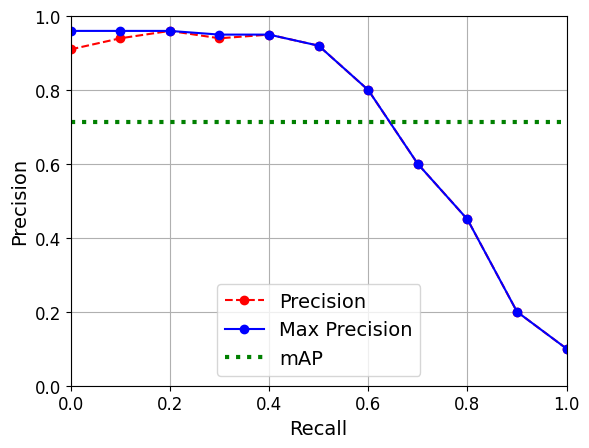

In [39]:
# mAP 함수 시각화
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

### 분류 와 위치 추정

### 분류 모델 생성

#### 데이터 가져오기

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
class_names = info.features["label"].names
print(class_names)

n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
print(dataset_size)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
3670


#### 데이터 분리

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

#### 이미지 출력

2022-04-15 17:41:22.241283: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


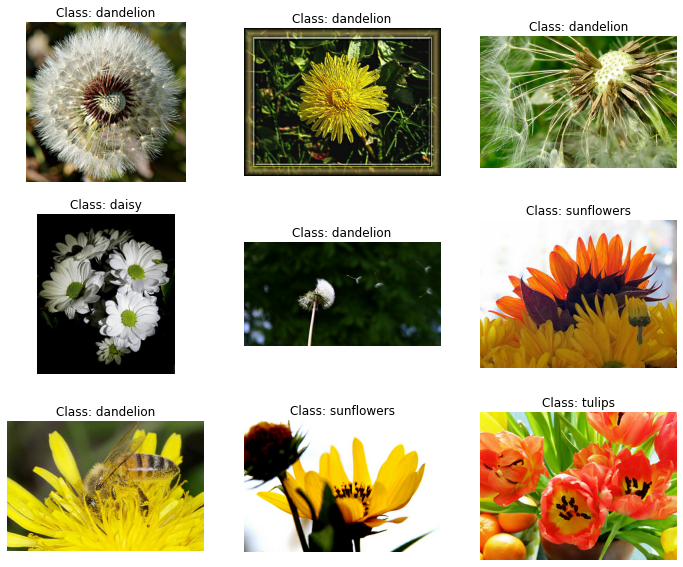

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

#### 이미지 처리 함수

In [ ]:
from functools import partial

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

#### 배치 크기 설정

In [ ]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

#### 전처리 된 이미지 출력

2022-04-15 17:42:11.164629: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


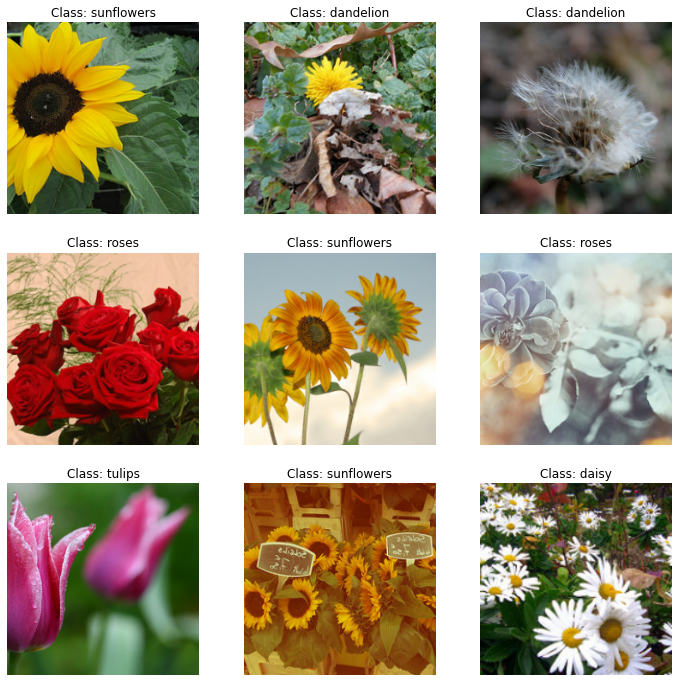

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

#### 모델 생성 및 컴파일

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)


base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

#### 모델 훈련

In [ ]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 81s 13s/step - loss: 1.3255 - dense_9_loss: 1.5822 - dense_10_loss: 0.2988 - dense_9_accuracy: 0.2250 - dense_10_accuracy: 0.1875
Epoch 2/2


2022-04-15 17:44:03.206228: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5/5 [==============================] - 70s 14s/step - loss: 1.1609 - dense_9_loss: 1.4051 - dense_10_loss: 0.1839 - dense_9_accuracy: 0.5188 - dense_10_accuracy: 0.2250


2022-04-15 17:45:12.896104: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### 텐서 플로우 허브의 Open Images v4 데이터 셋으로 학습된 모델 사용

#### import

In [ ]:
import tensorflow as tf  # tensorflow
import tensorflow_hub as tfhub  # tensorflow hub

#### 샘플 이미지 다운로드

352256/336122 [===============================] - 1s 2us/step


2022-04-17 10:05:19.429490: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


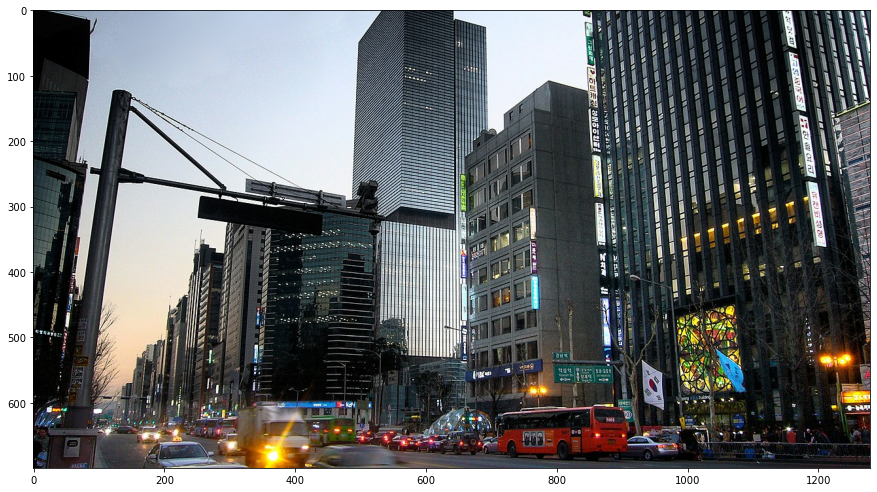

In [ ]:
# 샘플 이미지 다운로드
img_path = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Gangnam_Seoul_January_2009.jpg/1280px-Gangnam_Seoul_January_2009.jpg'
img = tf.keras.utils.get_file(fname='gangnam', origin=img_path)
img = tf.io.read_file(img)   # 파일 객체를 string으로 변환
img = tf.image.decode_jpeg(img, channels=3)   # 문자(string)를 숫자(unit8) 텐서로 변환
img = tf.image.convert_image_dtype(img, tf.float32)   # 0 ~ 1 범위로 정규화

import matplotlib.pylab as plt
plt.figure(figsize=(15, 10))
plt.imshow(img)

#### 4차원 텐서로 변환

In [ ]:
img_input = tf.expand_dims(img, 0)  # batch_size 추가
img_input.shape

TensorShape([1, 700, 1280, 3])

#### TensorFlow Hub에서 모델 가져오기 - FasterRCNN+InceptionResNet V2

In [ ]:
model = tfhub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


#### 모델 시그니처 확인

In [ ]:
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7F909FB20EB0>}))

#### 객체 탐지 모델 생성

In [ ]:
obj_detector = model.signatures['default']
obj_detector

<ConcreteFunction pruned(images) at 0x7F909FB20EB0>

#### 객체 탐지 모델 추론

In [ ]:
result = obj_detector(img_input)
result.keys()

2022-04-17 10:10:41.912773: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2484 } dim { size: -2485 } dim { size: -2486 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shap

dict_keys(['detection_class_names', 'detection_scores', 'detection_class_labels', 'detection_class_entities', 'detection_boxes'])

#### 탐지한 객체 수 확인

In [ ]:
len(result["detection_scores"])

100

#### 시각화

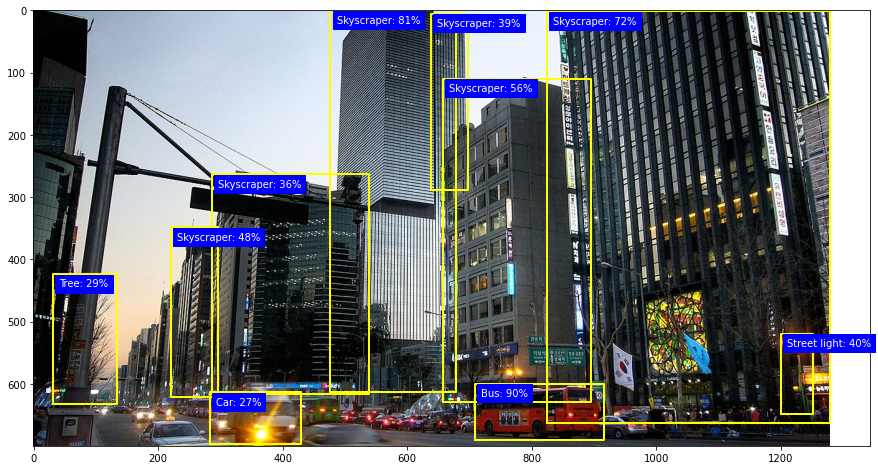

In [ ]:
# 객체 탐지 결과를 시각화
boxes = result["detection_boxes"]    # Bounding Box 좌표 예측값
labels = result["detection_class_entities"]   # 클래스 값
scores = result["detection_scores"]   # 신뢰도 (confidence)

# 샘플 이미지 가로 세로 크기
img_height, img_width = img.shape[0], img.shape[1]

# 탐지할 최대 객체의 수
obj_to_detect = 10

# 시각화
plt.figure(figsize=(15, 10))
for i in range(min(obj_to_detect, boxes.shape[0])):
    if scores[i] >= 0.2:
        (ymax, xmin, ymin, xmax) = (boxes[i][0]*img_height, boxes[i][1]*img_width,
                                    boxes[i][2]*img_height, boxes[i][3]*img_width)

        plt.imshow(img)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],
                 color='yellow', linewidth=2)

        class_name = labels[i].numpy().decode('utf-8')
        infer_score = int(scores[i].numpy()*100)
        annotation = "{}: {}%".format(class_name, infer_score)
        plt.text(xmin+10, ymax+20, annotation,
                 color='white', backgroundcolor='blue', fontsize=10)


## Semantic Segmentation

### 필수 라이브러리 불러오기

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
# 반려동물 이미지를 가져오기 위한 데이터 셋
import tensorflow_datasets as tfds

#colab
#from google.colab.patches import cv2_imshow

### 변수 설정

In [22]:
# 이미지 크기를 변수로 설정
img_w = 128 # 가로
img_h = 128 # 세로
img_c = 3 # 채널의 수
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 5 # 훈련 횟수
learning_rate = 0.0001
buffer_size = 1000 # 버퍼의 크기
batch_size = 16 # 배치의 크기

### 데이터 가져오기

In [23]:
# TensorFlow 데이터셋 로드
# 반려동물 이미지 가져오기

ds_str='oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6WMITC/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6WMITC/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


### 이미지 전처리 함수

In [24]:
def preprocess_image(ds):
    # 원본 이미지를 지정한 크기로 조절
    img = tf.image.resize(ds['image'], (img_w, img_h))
    # 형을 변환해서 정규화
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크 - 실제 반려 동물의 모양을 리사이징 해서 저장
    # 데이터 셋에 반려 동물의 모양이 마스킹 되어서 저장되어 있음
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1

    return img, mask

### 데이터 전처리 파이프라인

In [25]:
# 훈련 데이터와 테스트 데이터에 전처리 작업(preprocess_image)을 하고
# buffer size 만큼의 데이터를 섞은 후
# batch size 단위로 데이터를 prefetch
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
# 배치 처리를 할 때 prefetch 는 거의 필수
# 배치는 일정한 단위로 묶어서 처리하는 것이고 prefeth 는 데이터를 미리 가져오는 것

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


### 샘플 배치 선택

In [26]:
# 배치를 사용할 때는 iterator 를 만들어서 배치 단위로 접근 가능한 포인터를 생성
# next 를 사용해서 다음 데이터를 가져올 수 있도록
img, mask = next(iter(train_ds))
len(img) # batch_size 가 16이므로 16개씩 데이터를 가져옴

16

### 샘플 이미지 출력

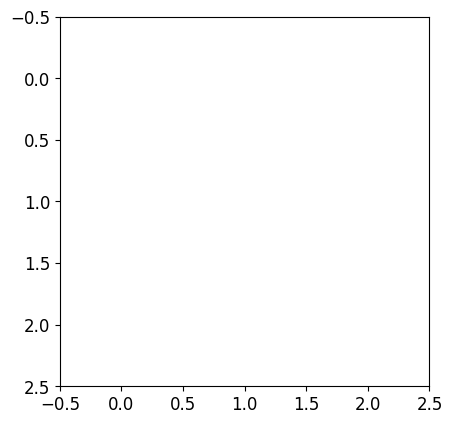

In [29]:
# 첫번째 배치의 첫번재 이미지를 출력

# 정규화를 수행할 때 255.0으로 나눴기 때문에
# 화면에 출력할 때는 다시 255를 곱해서 원래 이미지로 출력
img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)

#cv2_imshow(img)

### 샘플 마스크 출력

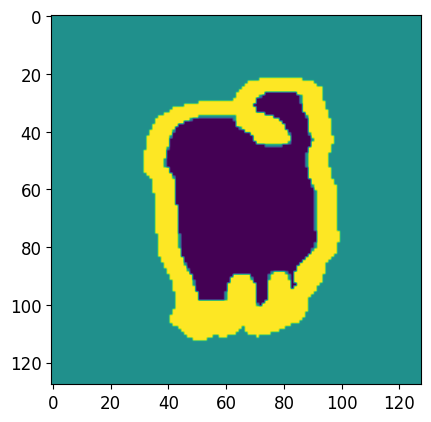

In [30]:
# 동물의 모양이 마스킹 된 마스크를 출력해서 확인

mask = (np.array(mask[0])/2)*255.0
plt.imshow(mask)

#cv2_imshow(mask)

### 전이 학습

In [31]:
# VGG16 모델을 인코더로 사용

# 자신에게 의미 분할을 수행하기 위한 모델이 있으면 그 모델을 사용하면 되는데
# 자신의 모델을 사용하려 한다면 많은 데이터를 가지고 학습을 해야 함
# 지금은 훈련 데이터가 많지 않기 때문에 VGG16 모델을 가져와서 인코더로 사용
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


### 모델 구조

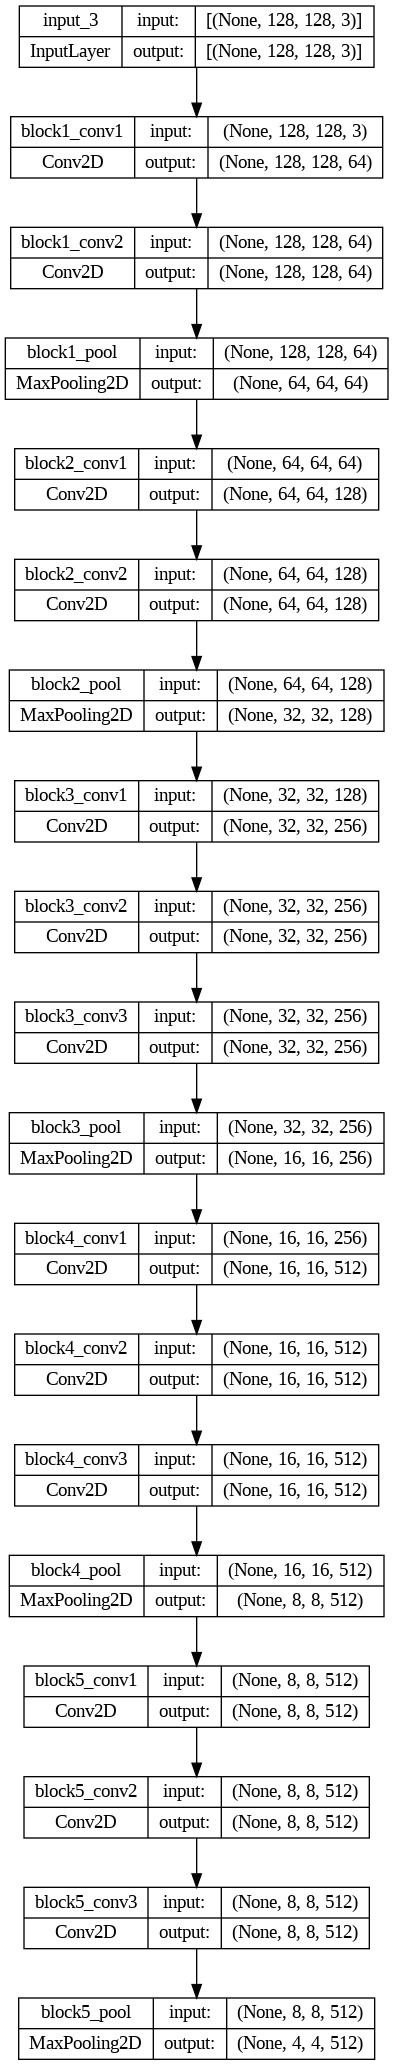

In [32]:
# 모델의 구조 확인
# 딥러닝 프로젝트나 포트폴리오를 만드는 경우에는 이 이미지를 첨부해서 사용
# 딥러닝에서는 이 모델이 어떤 구조로 만들어진 것인지 보여주는 이미지
tf.keras.utils.plot_model(base_model,show_shapes=True)

### VGG16 중간 레이어 출력 텐서를 지정

In [33]:
# input 으로는 만든 VGG 모델에서 가져오고
# 출력은 여러 개를 만듦
# 출력에 사용하는 name 은 위의 모델 구조에 나온 이름으로 수정

f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                                base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
])

### 파라미터 고정

In [34]:
f_model.trainable = False

### U-Net 구조로 모델 정의

In [35]:
# U-Net 은 Semantic Segmentation 을 수행해주는 모델

i=tf.keras.Input(shape=img_shape)

# 앞에서 만들어진 모든 출력을 별도로 저장
# 이름은 아무렇게나 사용해도 상관 없지만 이렇게 사용한 이유는
# 각 합성곱 층의 shape 를 그대로 옮겨 적은 것
out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

### 모델 구조 시각화

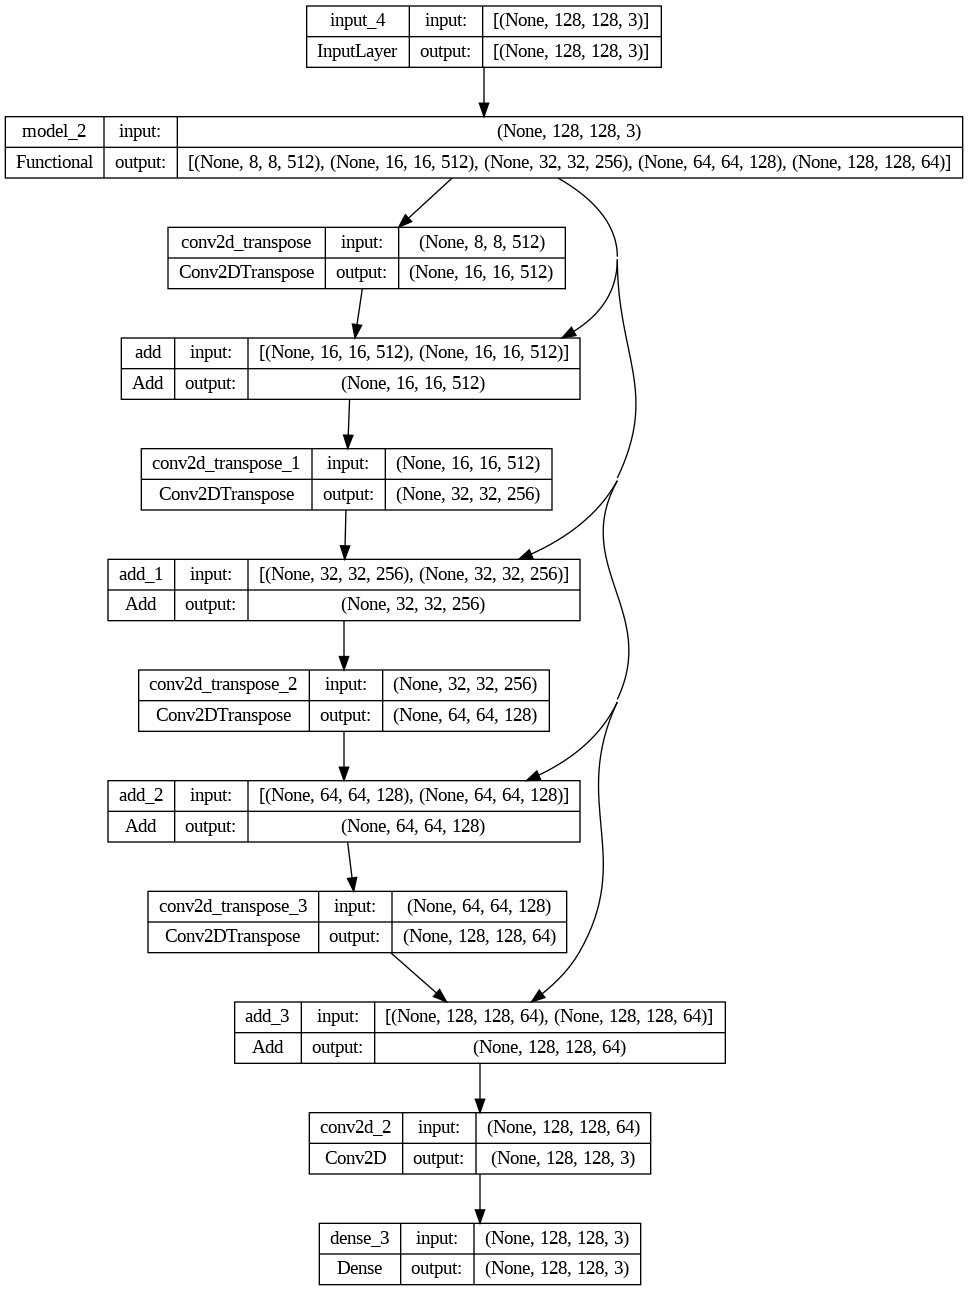

In [36]:
tf.keras.utils.plot_model(unet_model,show_shapes=True)

### 모델 구조 요약

In [37]:
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        [(None, 8, 8, 512),          1471468   ['input_4[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

### 모델 컴파일 및 훈련

In [ ]:
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


230/230 [==============================] - 623s 3s/step - loss: 0.8210 - accuracy: 0.6541
Epoch 2/5


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


230/230 [==============================] - 638s 3s/step - loss: 0.6081 - accuracy: 0.7661
Epoch 3/5


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


230/230 [==============================] - 572s 2s/step - loss: 0.5789 - accuracy: 0.7825
Epoch 4/5


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


230/230 [==============================] - 621s 3s/step - loss: 0.5605 - accuracy: 0.7922
Epoch 5/5


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


230/230 [==============================] - 623s 3s/step - loss: 0.5475 - accuracy: 0.7984


### 추론

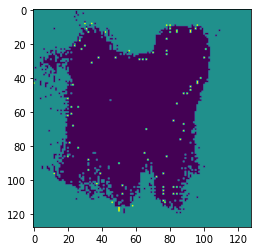

In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

### 첫번째 이미지의 정답 마스크 출력

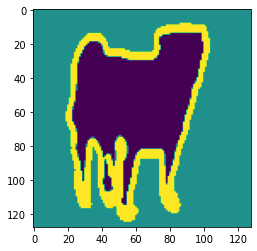

In [ ]:
plt.imshow(np.reshape(mask[0], (128,128)))